In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()

True

In [9]:
import os
print(os.getenv("OPENROUTER_API_KEY"))

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


In [11]:
model = ChatOpenAI(base_url="https://openrouter.ai/api/v1",model="openai/gpt-oss-120b",api_key=os.getenv("OPENROUTER_API_KEY"))

In [12]:
model.invoke("hi")

AIMessage(content='Hello! 👋 How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 55, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 38, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'cost': 1.2595e-05, 'is_byok': False, 'cost_details': {'upstream_inference_cost': 1.2595e-05, 'upstream_inference_prompt_cost': 2.145e-06, 'upstream_inference_completions_cost': 1.045e-05}}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': None, 'id': 'gen-1770296395-lyVUu0ZqIlEwYNtgYwAD', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c2de3-46db-7742-9a56-c7ef72a8d1e2-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 55, 'output_tokens': 55, 'total_tokens': 110, 'input_token_details': {'audio': 0, 'cache_read': 0

# Email fetching part

In [ ]:
from typing import List
from pydantic import BaseModel
from src.ingestion.gmail.gmail_auth import get_gmail_service
from datetime import datetime, timedelta
import base64
import os
from bs4 import BeautifulSoup
import re
ATTACHMENT_DIR = "attachments"
os.makedirs(ATTACHMENT_DIR, exist_ok=True)


# =====================
# SCHEMA
# =====================
class Metadata(BaseModel):
    sender: str
    to: List[str]
    subject: str
    date: str
    labels: List[str]


class Intent(BaseModel):
    email_type: str
    source: str = "heuristic"
    confidence: float | None = None


class Content(BaseModel):
    cleaned_text: str


class EmailObject(BaseModel):
    message_id: str
    thread_id: str
    metadata: Metadata
    intent: Intent
    content: Content
    attachments: List[dict] = []


# =====================
# HELPERS
# =====================
def decode_base64(data):
    return base64.urlsafe_b64decode(data).decode("utf-8", errors="ignore")



def normalize_text(text: str) -> str:
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)


    text = text.replace('\xa0', ' ')

    text = re.sub(r'\s+', ' ', text)

    return text.strip()



def parse_to_header(to_header: str | None) -> List[str]:
    if not to_header:
        return []
    return [addr.strip() for addr in to_header.split(",")]


def clean_html(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")

    for tag in soup(["style", "script", "head", "meta", "noscript"]):
        tag.decompose()

    for img in soup.find_all("img"):
        img.decompose()

    text = soup.get_text(separator="\n")
    lines = [l.strip() for l in text.splitlines() if 40 < len(l.strip()) < 300]

    return "\n".join(lines[:15])


def classify_email(headers, plain, html, labels):
    if "CATEGORY_PROMOTIONS" in labels:
        return "newsletter"
    if "CATEGORY_SOCIAL" in labels:
        return "notification"
    if html and len(html) > 5000:
        return "newsletter"
    if plain and len(plain) < 300:
        return "transactional"
    return "personal"


# =====================
# RAW BODY EXTRACTION
# =====================
def extract_raw_bodies(service, msg_id, payload):
    plain_text = None
    html_text = None
    attachments = []

    def walk(parts):
        nonlocal plain_text, html_text

        for part in parts:
            mime = part.get("mimeType")
            filename = part.get("filename")

            if filename and part["body"].get("attachmentId"):
                att_id = part["body"]["attachmentId"]
                att = service.users().messages().attachments().get(
                    userId="me", messageId=msg_id, id=att_id
                ).execute()

                data = base64.urlsafe_b64decode(att["data"])
                path = os.path.join(ATTACHMENT_DIR, filename)

                with open(path, "wb") as f:
                    f.write(data)

                attachments.append({"filename": filename, "path": path})

            elif part["body"].get("data"):
                data = decode_base64(part["body"]["data"])
                if mime == "text/plain":
                    plain_text = data
                elif mime == "text/html":
                    html_text = data

            if part.get("parts"):
                walk(part["parts"])

    if payload.get("parts"):
        walk(payload["parts"])
    elif payload.get("body", {}).get("data"):
        mime = payload.get("mimeType")
        data = decode_base64(payload["body"]["data"])
        if mime == "text/plain":
            plain_text = data
        elif mime == "text/html":
            html_text = data

    return plain_text, html_text, attachments


# =====================
# MAIN INGESTION
# =====================
def read_emails_in_date_range(start_date: str, end_date: str) -> List[EmailObject]:
    service = get_gmail_service()

    start = datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=1)
    end = datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)
    query = f"after:{start.strftime('%Y/%m/%d')} before:{end.strftime('%Y/%m/%d')}"

    results = []
    response = service.users().messages().list(
        userId="me", q=query, maxResults=100
    ).execute()

    for m in response.get("messages", []):
        msg = service.users().messages().get(
            userId="me", id=m["id"], format="full"
        ).execute()

        headers = {h["name"]: h["value"] for h in msg["payload"]["headers"]}
        labels = msg.get("labelIds", [])

        plain, html, attachments = extract_raw_bodies(
            service, m["id"], msg["payload"]
        )

        email_type = classify_email(headers, plain, html, labels)

        if email_type == "newsletter" and html:
            cleaned = clean_html(html)
            cleaned = normalize_text(cleaned)
        else:
            cleaned = plain or clean_html(html or "")
            cleaned = normalize_text(plain)

        email = EmailObject(
            message_id=msg["id"],
            thread_id=msg["threadId"],
            metadata=Metadata(
                sender=headers.get("From", ""),
                to=parse_to_header(headers.get("To")),
                subject=headers.get("Subject", ""),
                date=headers.get("Date", ""),
                labels=labels
            ),
            intent=Intent(
                email_type=email_type,
                source="heuristic",
                confidence=0.6
            ),
            content=Content(
                cleaned_text=cleaned
            ),
            attachments=attachments
        )

        results.append(email)

    return results


In [5]:
read_emails_in_date_range("2026-02-1","2026-02-5")

[EmailObject(message_id='19c2f9c404033f88', thread_id='19c2f9c404033f88', metadata=Metadata(sender='Kaggle <no-reply@kaggle.com>', to=['gpt1410@gmail.com'], subject='🏆 Game Arena Winners: Poker, Werewolf, and Chess ', date='Thu, 05 Feb 2026 13:01:34 -0800', labels=['UNREAD', 'CATEGORY_UPDATES', 'INBOX']), intent=Intent(email_type='newsletter', source='heuristic', confidence=0.6), content=Content(cleaned_text="event of 2026 has officially concluded. From the logic of Chess to the social dynamics of Werewolf and the calculated risks of Poker, we’ve seen AI models navigate complex environments in dynamic ways. Here are the champions from the final leaderboards 👇 From each leaderboard you can find all of the underlying datasets, game replays, model reasoning outputs and environments, open sourced for further analysis. Missed the action? We’ve compiled all the expert commentary from Hikaru Nakamura, Nick Schulman, Doug Polk, and Liv Boeree into a single Kaggle, Inc 1600 Amphitheatre Pkwy Mo

In [ ]:
# getting the content now convert the content to proper format

In [20]:
b = [{"m":{"name":"Manas"}},{"m":{"name":"Madnas"}},{"n":{"name":"qwqdqw"}}]
from collections import defaultdict

a = defaultdict(list)

for c in b:
    key = list(c.keys())[0]
    a[key].append(c[key]["name"])

a = dict(a)

In [21]:
print(a)

{'m': ['Manas', 'Madnas'], 'n': ['qwqdqw']}


In [8]:
def split_paragraphs(text: str) -> list[str]:
    return [p.strip() for p in text.split("\n\n") if p.strip()]
a = """
manas Tiwari

Hello everyone

How are you doing.
"""

para = split_paragraphs(a)
para

['manas Tiwari', 'Hello everyone', 'How are you doing.']

In [6]:
b = """"""
for n,c in enumerate(para):
    b+=f"{n}. {c}\n"

In [7]:
b

'0. manas Tiwari\n1. Hello everyone\n2. How are you doing.\n'

In [13]:
prev_summary = ["a"]
previous_summary_points = """"""
for num,para in enumerate(prev_summary):
    previous_summary_points+=f"[S{num}] {para}\n"

In [14]:
previous_summary_points == ""

False

In [15]:
previous_summary_points

'[S0] a\n'

In [16]:
a = {"Manas":['a','b','c'],"Messi":["r","o","n"]}

In [19]:
[x for y,x in a.items()]

[['a', 'b', 'c'], ['r', 'o', 'n']]

In [18]:
a.keys()

dict_keys(['Manas', 'Messi'])

In [20]:
a = []

In [21]:
a.append('b')

In [22]:
a

['b']

In [23]:
a = ["c"]

In [24]:
a

['c']

In [1]:
from src.prompts.router_agent_prompt import SYSTEM_PROMPT_ROUTER_AGENT,PROMPT_VERSION_ROUTER_AGENT,build_router_agent_prompt
from src.llm.service import call_llm_cached
from src.schema.email_object import EmailObject
from src.schema.router_schema import RouterSchema
from typing import List,TypedDict,Dict,Literal,Any,Annotated
from langgraph.graph import StateGraph,START,END
from langgraph.types import Command,Send
from src.ingestion.batching import batch_by_sender_and_time
from src.config import MODEL_NAME
from operator import or_

C:\Users\offic\OneDrive\Desktop\Python-Learning\Data Science\LangGraph-V1.0\MailMind\data\cache_data\llm_cache.db


In [2]:
class RouterState(TypedDict):
    emails: List[EmailObject]
    batches: Dict[str,List[EmailObject]]
    actions: Annotated[Dict[str,RouterSchema],or_]
    cache: Any
    llm: Any
    provider: Any
    
def batch_emails(state: RouterState):
    print(state)
    emails = state["emails"]
    print(emails)
    batch:Dict[str,List[EmailObject]] = batch_by_sender_and_time(emails=emails)
    return {"batches":batch}
def fan_out_batches(state: RouterState):
    batch = state["batches"]
    
    return [
        
        Send("process_batch",{"batch_emails":emails,"cache":state["cache"],"llm":state["llm"],"provider":state["provider"]}) for _,emails in batch.items()
        
    ]
    
def process_batch(state: RouterState):
    emails:List[EmailObject] = state["batch_emails"]
    email_context = []
    actions = {}
    for email in emails:
        email_prompt  = build_router_agent_prompt(email=email,prev_summary=email_context)
        result:RouterSchema = call_llm_cached(cache=state["cache"],llm=state["llm"],provider=state["provider"],model_name=MODEL_NAME,system_prompt=SYSTEM_PROMPT_ROUTER_AGENT,user_prompt=email_prompt,output_schema=RouterSchema,prompt_version=PROMPT_VERSION_ROUTER_AGENT,agent_name="RouterAgent",cache_enabled=True)
        email_context = result.rolling_summary
        actions[email.message_id] = result
    
    return {"actions":actions}
    

In [ ]:
workflow = StateGraph(state_schema=RouterState)
workflow.add_node("batch_emails",batch_emails)
workflow.add_node("fan_out_batches",fan_out_batches)
workflow.add_node("process_batch",process_batch)

workflow.add_edge(START,"batch_emails")
workflow.add_conditional_edges("batch_emails",fan_out_batches,["process_batch"])
workflow.add_edge("process_batch",END)

agent = workflow.compile()

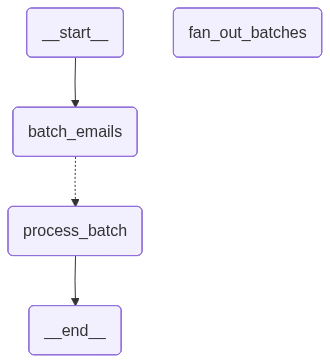

In [4]:
agent

In [5]:
import os
os.getenv("OPENROUTER_API_KEY")

'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'

In [6]:
from langchain_openai import ChatOpenAI
import os
model = ChatOpenAI(base_url="https://openrouter.ai/api/v1",model="openai/gpt-oss-120b",api_key=os.getenv("OPENROUTER_API_KEY"))

AIMessage(content='Hello! 👋 How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 68, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 28, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'cost': 2.268e-05, 'is_byok': False, 'cost_details': {'upstream_inference_cost': 2.268e-05, 'upstream_inference_prompt_cost': 6.12e-06, 'upstream_inference_completions_cost': 1.656e-05}}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': None, 'id': 'gen-1770631778-lhunfbN3ktOiDWRE6HJ6', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c41e0-c58e-7ee3-9bb0-a7e71c7ac0d7-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 68, 'output_tokens': 46, 'total_tokens': 114, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

In [8]:
from src.llm.cache import SQLiteLLMCache
from src.config import DB_PATH
from src.llm.providers.gpt import OpenAIProvider
def build_initial_state(*,
    model_name = MODEL_NAME):
    
    cache = SQLiteLLMCache(db_path=DB_PATH)

    # llm = ChatGoogleGenerativeAI(
    #     model=model_name,
    #     temperature=0.0,
    # )
    llm = ChatOpenAI(base_url="https://openrouter.ai/api/v1",model="openai/gpt-oss-120b",api_key=os.getenv("OPENROUTER_API_KEY"))

    provider = OpenAIProvider()

    return {
        "cache": cache,
        "llm": llm,
        "provider": provider,
        "emails":[],
        "batches":{},
        "actions":{}
    }


In [9]:
import src.ingestion.pipeline
print(src.ingestion.pipeline.__file__)


c:\Users\offic\OneDrive\Desktop\Python-Learning\Data Science\LangGraph-V1.0\MailMind\src\ingestion\pipeline.py


In [10]:
import importlib
import src.ingestion.pipeline

importlib.reload(src.ingestion.pipeline)
from src.ingestion.pipeline import read_emails_in_date_range

emails = read_emails_in_date_range("2026-02-1","2026-02-2")

here
1770057187000
1770055561000
1770054454000
1769968052000
1769967626000
1769967543000
1769902197000
1769881649000
1769867100000


In [11]:
print(len(emails))
emails

9


[EmailObject(message_id='19c1fa1494d66bba', thread_id='19c1fa1494d66bba', metadata=Metadata(sender='"Math & Science Tutor (via Patreon)" <no-reply@patreon.com>', to=['gpt1410@gmail.com'], subject='"Limits Test Review - Part 1" and 2 more', date='Mon, 02 Feb 2026 18:33:07 +0000', labels=['CATEGORY_UPDATES', 'INBOX'], internal_timestamp=1770057187000), intent=Intent(email_type='newsletter', source='heuristic', confidence=0.6), content=Content(cleaned_text=NormalizedContent(text="Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon.", paragraphs=["Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon."])), attachments=[]),
 EmailObject(message_id='19c1f8872b924d2d', thread_id='19c1f8872b924d2d', metadata=Metadata(sender='Kaggle <no-reply@kaggle.com>', to=['gpt1410@gmail.com'], subject=' 📺 The Game Arena is Open: Watch AI model

In [12]:
DB_PATH

WindowsPath('C:/Users/offic/OneDrive/Desktop/Python-Learning/Data Science/LangGraph-V1.0/MailMind/data/cache_data/llm_cache.db')

In [13]:
init_state = build_initial_state()

In [14]:
init_state["emails"] = emails

In [15]:
init_state = dict(init_state)

In [16]:
init_state

{'cache': <src.llm.cache.SQLiteLLMCache at 0x1ee42e4c390>,
 'llm': ChatOpenAI(profile={}, client=<openai.resources.chat.completions.completions.Completions object at 0x000001EE42E8B7D0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001EE42ACCE90>, root_client=<openai.OpenAI object at 0x000001EE42269410>, root_async_client=<openai.AsyncOpenAI object at 0x000001EE42E8AA50>, model_name='openai/gpt-oss-120b', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://openrouter.ai/api/v1'),
 'provider': <src.llm.providers.gpt.OpenAIProvider at 0x1ee401c6c50>,
 'emails': [EmailObject(message_id='19c1fa1494d66bba', thread_id='19c1fa1494d66bba', metadata=Metadata(sender='"Math & Science Tutor (via Patreon)" <no-reply@patreon.com>', to=['gpt1410@gmail.com'], subject='"Limits Test Review - Part 1" and 2 more', date='Mon, 02 Feb 2026 18:33:07 +0000', labels=['CATEGORY_UPDATES', 'INBOX'], internal_timestamp=1770057187000), inte

In [17]:
result = agent.invoke(init_state)

{'emails': [EmailObject(message_id='19c1fa1494d66bba', thread_id='19c1fa1494d66bba', metadata=Metadata(sender='"Math & Science Tutor (via Patreon)" <no-reply@patreon.com>', to=['gpt1410@gmail.com'], subject='"Limits Test Review - Part 1" and 2 more', date='Mon, 02 Feb 2026 18:33:07 +0000', labels=['CATEGORY_UPDATES', 'INBOX'], internal_timestamp=1770057187000), intent=Intent(email_type='newsletter', source='heuristic', confidence=0.6), content=Content(cleaned_text=NormalizedContent(text="Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon.", paragraphs=["Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon."])), attachments=[]), EmailObject(message_id='19c1f8872b924d2d', thread_id='19c1f8872b924d2d', metadata=Metadata(sender='Kaggle <no-reply@kaggle.com>', to=['gpt1410@gmail.com'], subject=' 📺 The Game Arena is Open: Watc

In [18]:
result

{'emails': [EmailObject(message_id='19c1fa1494d66bba', thread_id='19c1fa1494d66bba', metadata=Metadata(sender='"Math & Science Tutor (via Patreon)" <no-reply@patreon.com>', to=['gpt1410@gmail.com'], subject='"Limits Test Review - Part 1" and 2 more', date='Mon, 02 Feb 2026 18:33:07 +0000', labels=['CATEGORY_UPDATES', 'INBOX'], internal_timestamp=1770057187000), intent=Intent(email_type='newsletter', source='heuristic', confidence=0.6), content=Content(cleaned_text=NormalizedContent(text="Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon.", paragraphs=["Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon."])), attachments=[]),
  EmailObject(message_id='19c1f8872b924d2d', thread_id='19c1f8872b924d2d', metadata=Metadata(sender='Kaggle <no-reply@kaggle.com>', to=['gpt1410@gmail.com'], subject=' 📺 The Game Arena is Open: Wa

In [43]:
len(list(result["batches"].keys()))

6

In [19]:
result["batches"]


{'"Math & Science Tutor (via Patreon)" <no-reply@patreon.com>': [EmailObject(message_id='19c1fa1494d66bba', thread_id='19c1fa1494d66bba', metadata=Metadata(sender='"Math & Science Tutor (via Patreon)" <no-reply@patreon.com>', to=['gpt1410@gmail.com'], subject='"Limits Test Review - Part 1" and 2 more', date='Mon, 02 Feb 2026 18:33:07 +0000', labels=['CATEGORY_UPDATES', 'INBOX'], internal_timestamp=1770057187000), intent=Intent(email_type='newsletter', source='heuristic', confidence=0.6), content=Content(cleaned_text=NormalizedContent(text="Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon.", paragraphs=["Catch up on this month's top posts from Math & Science Tutor Explore more posts, see what other members are saying, and more on Patreon."])), attachments=[])],
 'Kaggle <no-reply@kaggle.com>': [EmailObject(message_id='19c1f8872b924d2d', thread_id='19c1f8872b924d2d', metadata=Metadata(sender='Kaggle <n

In [20]:
for key,value in result["batches"].items():
    if len(value) > 1:
        print(f"Key: {key}\nEmails:{value}\nTotal mails :{len(value)}")

Key: OpenRouter Team <welcome@openrouter.ai>
Emails:[EmailObject(message_id='19c152ac533799cc', thread_id='19c152ac533799cc', metadata=Metadata(sender='OpenRouter Team <welcome@openrouter.ai>', to=['gpt1410@gmail.com'], subject='Protecting your data: logging and training policies', date='Sat, 31 Jan 2026 17:47:29 +0000', labels=['UNREAD', 'CATEGORY_UPDATES', 'INBOX'], internal_timestamp=1769881649000), intent=Intent(email_type='newsletter', source='heuristic', confidence=0.6), content=Content(cleaned_text=NormalizedContent(text='OpenRouter never logs your prompts or responses by default. We only store metadata to keep your service running smoothly: Performance metrics for uptime optimization Generation activity you can access anytime Each provider has their own data retention and training policies, and you can check a straightforward summary By default, your paid requests never route to providers that train on your data. You can customize this further by: Setting data policies per requ

In [21]:
result["actions"]

{'19c1fa1494d66bba': RouterSchema(action='IGNORE', suggested_actions=[], explanation='The email is a routine promotional notification from Patreon about top posts from the Math & Science Tutor. It contains no requests, deadlines, or security concerns, so the least intrusive action that still respects the user’s inbox is to ignore it.', confidence=0.98, rolling_summary=['Received a Patreon email from Math & Science Tutor titled "Limits Test Review - Part 1" notifying about this month’s top posts.']),
 '19c1f8872b924d2d': RouterSchema(action='IGNORE', suggested_actions=['ADD_TO_CALENDAR', 'SUMMARIZE', 'DRAFT_REPLY'], explanation='The email is a promotional newsletter about an upcoming Kaggle livestream. It does not require any immediate user response or contain security concerns. Ignoring it is the least intrusive action while still ensuring the user is not disturbed. Suggested actions are offered for user convenience but are not executed automatically.', confidence=0.97, rolling_summary